### Dataset Import and Inspection

In [71]:
import warnings
warnings.filterwarnings('ignore')


from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline


# fetch dataset
heart_disease = fetch_ucirepo(id=45)


# df = pd.read_csv('/home/jem/DEV/MSAI/CSCA 5622 Introduction to Machine Learning: Supervised Learning/Module 7 - Final/data/heart_disease_uci.csv')

# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets

# metadata
# print(heart_disease.metadata)

# variable information
pd.DataFrame(heart_disease.variables)

X = heart_disease.data.features
y = heart_disease.data.targets

# Convert to dataframe
df = pd.concat([X, y], axis=1)

# Inspect data
df.head()
df.info() # ca and thal have null values
df.isna().sum()
(df == '?').sum() # no ? values
(df == 0).sum()

# ca and thal should not have 0 values (but they do)
# ca: number of major vessels (can't be 0)
# thal: thalassemia type (3 is normal, it can't be 0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


age           0
sex          97
cp            0
trestbps      0
chol          0
fbs         258
restecg     151
thalach       0
exang       204
oldpeak      99
slope         0
ca          176
thal          0
num         164
dtype: int64

###

### Data Cleanup

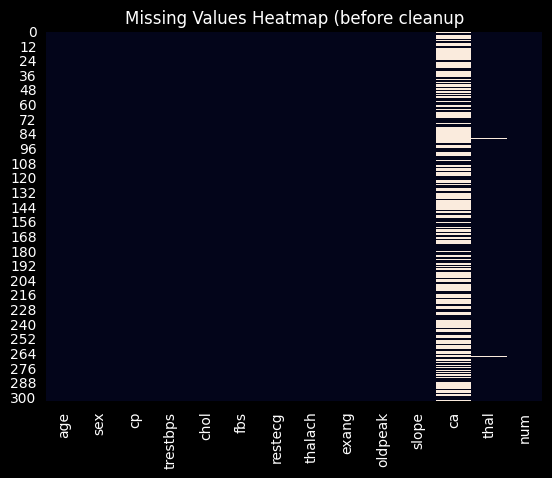

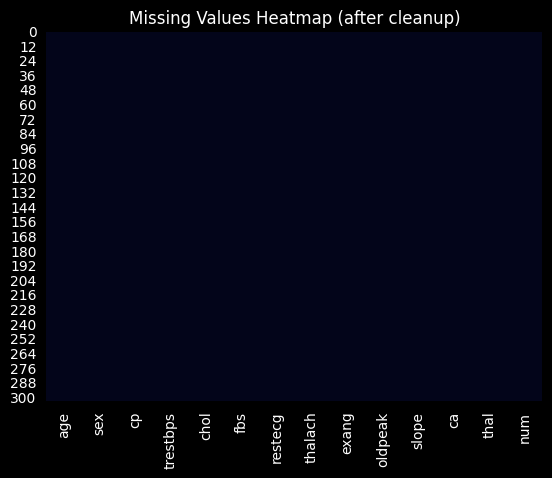

In [72]:
cols_w_invalid_zero = ['ca', 'thal']

# Convert 0's to NaN
for col in cols_w_invalid_zero:
    df[col] = df[col].replace(0,np.nan)

# Check if zeros are gone
(df == 0).sum()

sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Values Heatmap (before cleanup")
plt.show()

# ca and thal have NaN values

# convert zero values of the numerical feature ca to median
median_val = pd.to_numeric(df['ca'], errors='coerce').median()
df['ca'] = df['ca'].fillna(median_val)

# convert zero values of the categorical feature thal to mode (most frequent category)
mode_val = df['thal'].mode()[0]
df['thal'] = df['thal'].fillna(median_val)

# Check if there are missing values after cleanup
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Values Heatmap (after cleanup)")
plt.show()



### Check for class imbalance

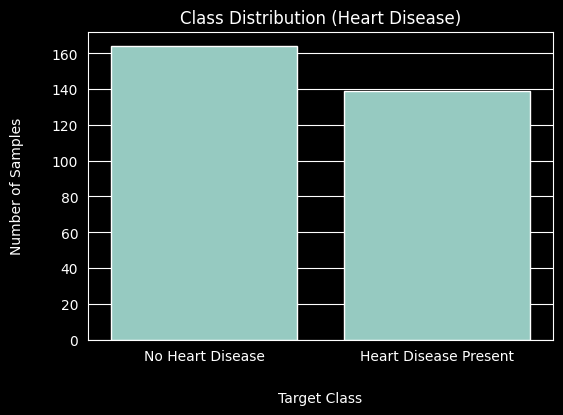

Class counts:
 num
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64

Class proportions:
 num
0    0.541254
1    0.181518
2    0.118812
3    0.115512
4    0.042904
Name: count, dtype: float64


In [73]:

# Count target classes
class_counts = df['num'].value_counts().sort_index()

# temporary counts to combine values 1-4 to 1 - Heart Disease Present
temp_counts = class_counts.groupby(lambda x: 1 if x > 0 else 0).sum()

plt.figure(figsize=(6,4))
sns.barplot(
    x=temp_counts.index,
    y=temp_counts.values
)

plt.xlabel('Target Class', labelpad=20)
plt.ylabel('Number of Samples', labelpad=20)
plt.title('Class Distribution (Heart Disease)')
plt.xticks()
plt.xticks([0, 1], ['No Heart Disease', 'Heart Disease Present'])

plt.show()

# Print counts and proportions
print("Class counts:\n", class_counts)
print("\nClass proportions:\n", class_counts / class_counts.sum())

# plot shows that small class imbalance with slightly
# more no heart disease observations than those with heart disease
#
# 164 people don't have heart disease
# 139 people have heart disease:
# ---------------------------------------
# 55 people have mild heart disease
# 36 people have moderate heart disease
# 35 people have severe heart disease
# 13 people have very severe heart disease

### EDA (Exploratory Data Analysis)

#### Numerical Feature Distribution

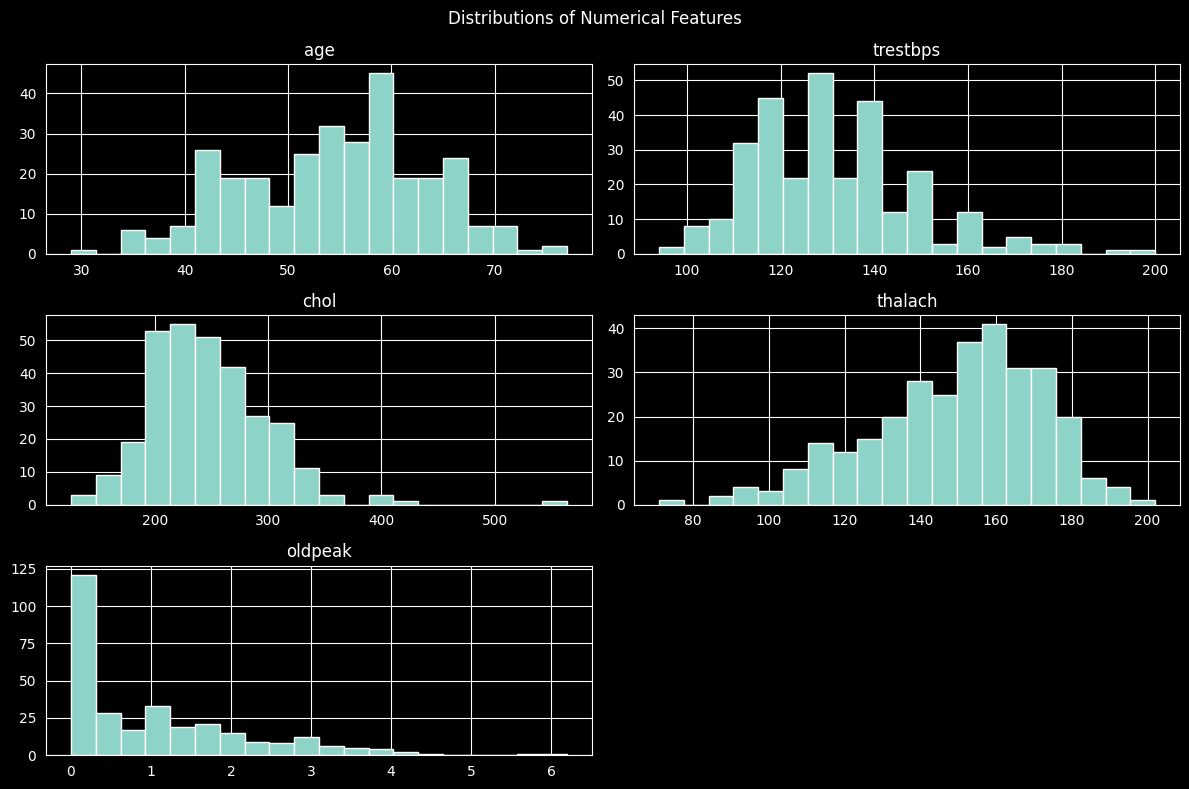

In [74]:
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

df[numerical_cols].hist(figsize=(12,8), bins=20)
plt.suptitle("Distributions of Numerical Features")
plt.tight_layout()
plt.show()

# Cholesterol and resting BP show potential outliers
# Age and Max HR are more symmetric

#### Outlier Detection

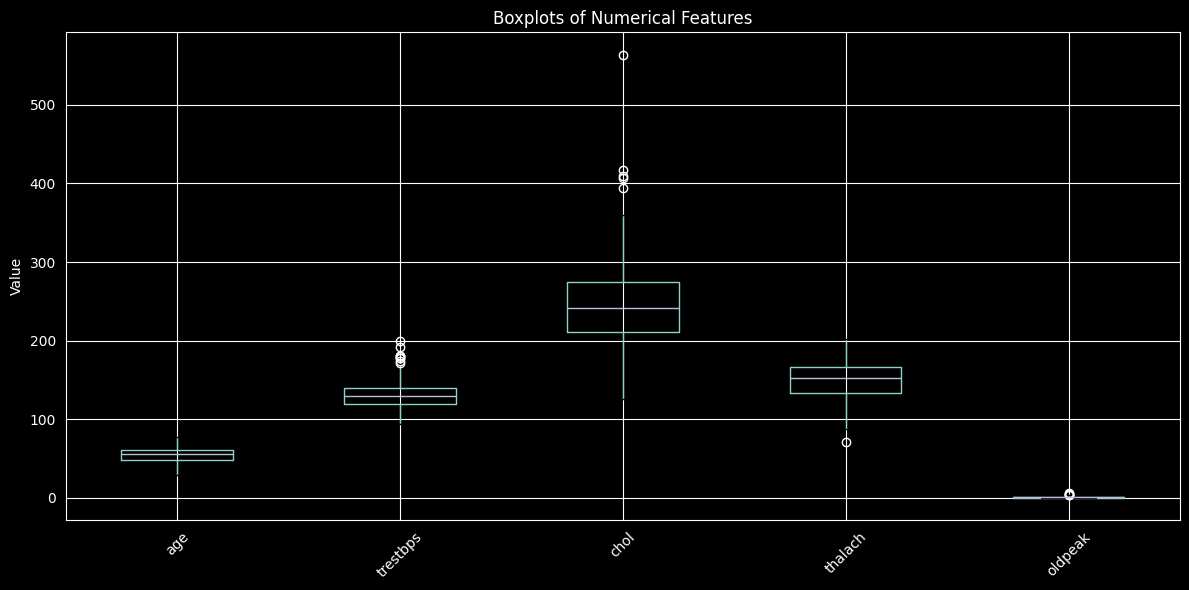

In [75]:
plt.figure(figsize=(12,6))
df[numerical_cols].boxplot()
plt.title("Boxplots of Numerical Features")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Cholesterol and oldpeak have outliers.

#### Counts of Categorical Features

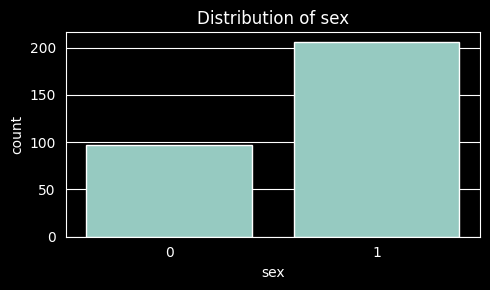

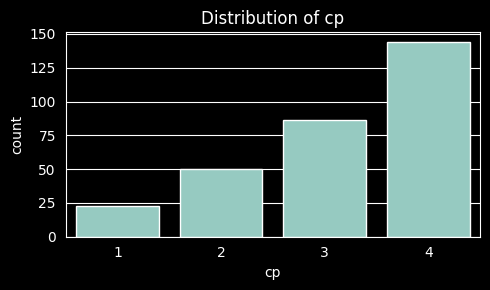

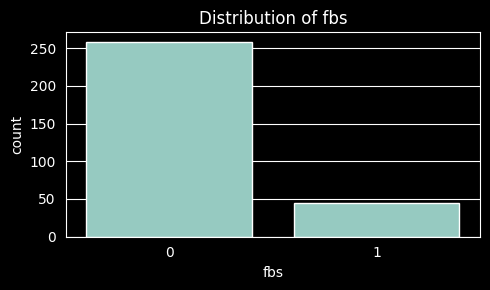

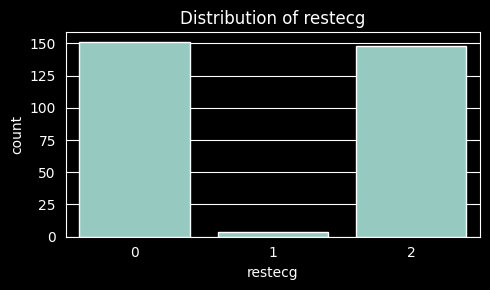

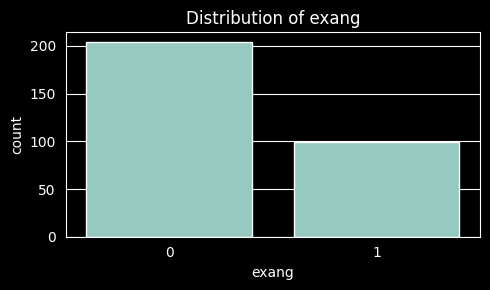

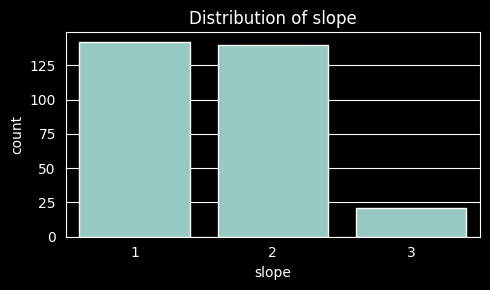

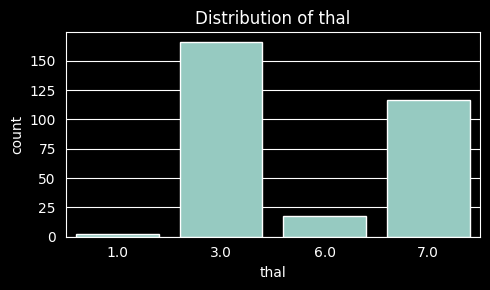

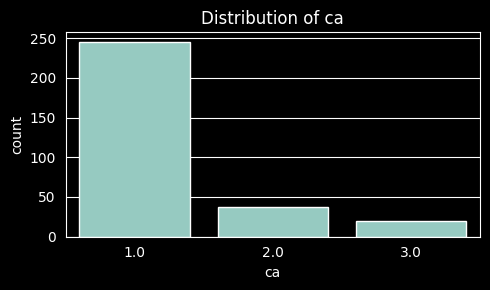

In [76]:
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'ca']

for col in categorical_cols:
    plt.figure(figsize=(5,3))
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

# Sex, Chest Pain Type (cp), and thalassemia (thal)
# vary widely => potentially powerful predictive features

### Numerical Features vs Target

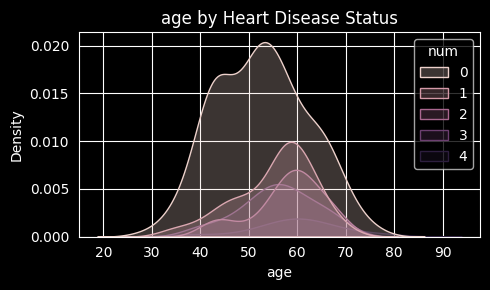

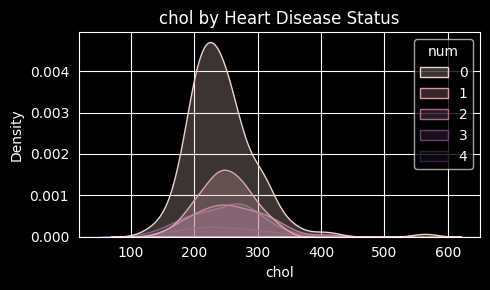

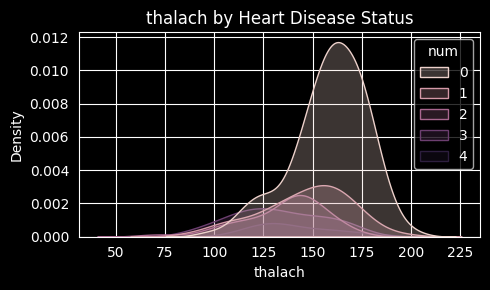

In [77]:
for col in ['age', 'chol', 'thalach']:
    plt.figure(figsize=(5,3))
    sns.kdeplot(data=df, x=col, hue='num', fill=True)
    plt.title(f'{col} by Heart Disease Status')
    plt.tight_layout()
    plt.show()

# People with heart disease tend to have lower max HR
# and somewhat higher cholesterol
# Age shows overlap, but disease class(es) it shifts older

#### Categorical Features vs Target

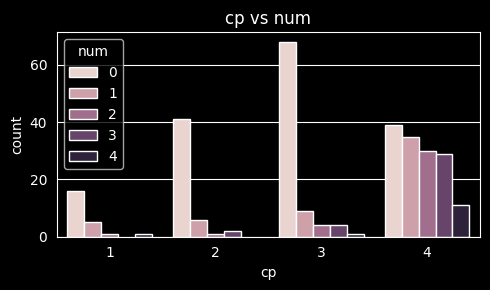

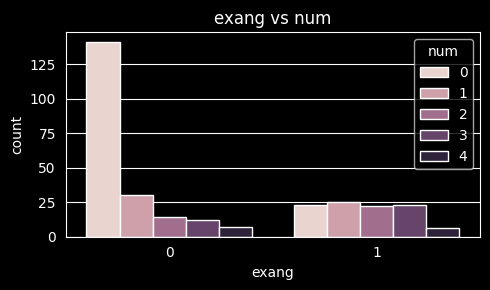

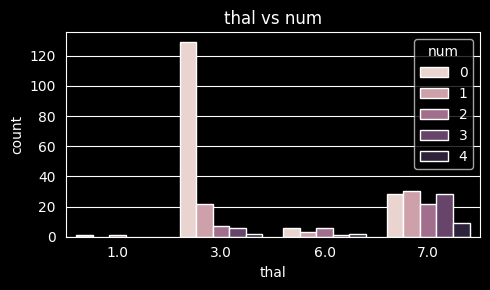

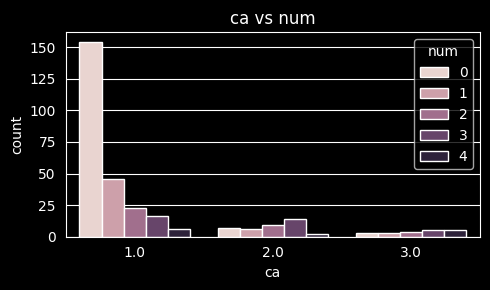

In [78]:
for col in ['cp', 'exang', 'thal', 'ca']:
    plt.figure(figsize=(5,3))
    sns.countplot(x=col, hue='num', data=df)
    plt.title(f'{col} vs num')
    plt.tight_layout()
    plt.show()

# Chest pain type (cp) and exercise induced angia (exang) show strong association
# w/ heart disease => likely to be very useful during modelling

#### Correlation Matrix and Heatmap

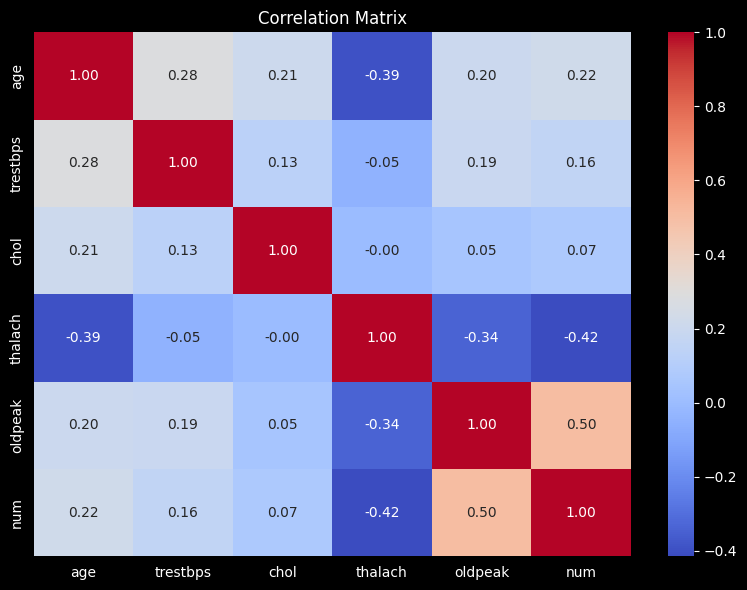

In [79]:
corr = df[numerical_cols + ['num']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# Max HR is negatively correlated w/ target
# Oldpeak is positively correlated w/ targt
# Some multicollinearity

In [80]:
#### Pairplot

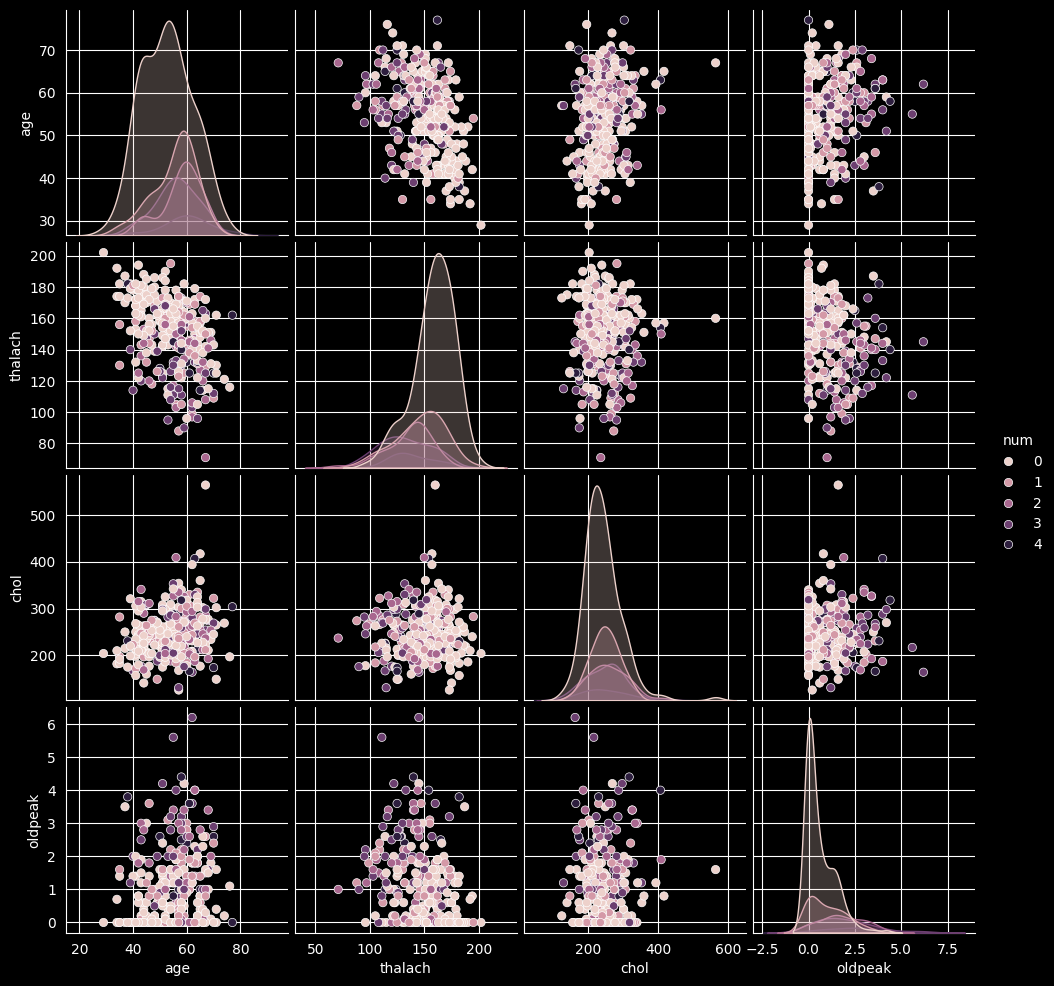

In [81]:
sns.pairplot(
    df[['age', 'thalach', 'chol', 'oldpeak', 'num']],
    hue='num'
)
plt.show()

# Max HR and Old Peak show some separation between classes
# => non-linear boundaries might work better vs linear models

#### EDA Summary

Chest pain type, max HR, exercise induced angia, and oldpeak show strong association w/ heart disease.

### Modeling

#### Evaluate Function

In [82]:
# Function to evaluate models in later sections
# It will be reused to determine accuracy, precision,
# recall, and ROC AUC

def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    return {
        'accuracy_score': accuracy_score(y_test, y_pred),
        'precision_score': precision_score(y_test, y_pred, average='weighted'),
        'recall_score': recall_score(y_test, y_pred, average='weighted'),
        'roc_auc_score': roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
    }

#### Train / Test Split

In [83]:
# Split data into features and target
X = df.drop(columns=['num'], axis=1)
y = df['num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Split X and y to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### Pre-processing Pipeline

In [84]:
# ColumnTransformer for numerical and categorical features

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler(), numerical_cols),
        ('categorical', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ]
)

#### Model 1 - Logistic Regression

In [85]:
from sklearn.linear_model import LogisticRegression

lr = Pipeline([
    ('preprocess', preprocessor),
    ('model', LogisticRegression(
        max_iter=1000,
        class_weight='balanced'
    ))
])

lr.fit(X_train, y_train)

lr_scores = evaluate(lr, X_test, y_test)
lr_scores

# {'accuracy_score': 0.3770491803278688,
#  'precision_score': 0.4288251366120218,
#  'recall_score': 0.3770491803278688,
#  'roc_auc_score': 0.7725512724318653}


{'accuracy_score': 0.3770491803278688,
 'precision_score': 0.4288251366120218,
 'recall_score': 0.3770491803278688,
 'roc_auc_score': 0.7725512724318653}

#### Model 2 - Random Forest

In [86]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',
        random_state=42
    ))
])

rf.fit(X_train, y_train)

rf_scores = evaluate(lr, X_test, y_test)
rf_scores

# {'accuracy_score': 0.3770491803278688,
#  'precision_score': 0.4288251366120218,
#  'recall_score': 0.3770491803278688,
#  'roc_auc_score': 0.7725512724318653}

{'accuracy_score': 0.3770491803278688,
 'precision_score': 0.4288251366120218,
 'recall_score': 0.3770491803278688,
 'roc_auc_score': 0.7725512724318653}

#### Model 3 - Support Vector Machine

In [87]:
from sklearn.svm import SVC

svm = Pipeline([
    ('preprocess', preprocessor),
    ('model', SVC(
        kernel='rbf',
        probability=True,
        class_weight='balanced'
    ))
])

svm.fit(X_train, y_train)

svm_scores = evaluate(svm, X_test, y_test)
svm_scores

# {'accuracy_score': 0.4262295081967213,
#  'precision_score': 0.4855645993350911,
#  'recall_score': 0.4262295081967213,
#  'roc_auc_score': 0.8164110516739014}

{'accuracy_score': 0.4262295081967213,
 'precision_score': 0.4855645993350911,
 'recall_score': 0.4262295081967213,
 'roc_auc_score': 0.8172110952409548}

#### Model 4 - Gradient Boosting

In [88]:
from sklearn.ensemble import GradientBoostingClassifier

gb = Pipeline([
    ('preprocess', preprocessor),
    ('model', GradientBoostingClassifier(random_state=42))
])

gb.fit(X_train, y_train)

gb_scores = evaluate(svm, X_test, y_test)
gb_scores

# {'accuracy_score': 0.4262295081967213,
#  'precision_score': 0.4855645993350911,
#  'recall_score': 0.4262295081967213,
#  'roc_auc_score': 0.8164110516739014}

{'accuracy_score': 0.4262295081967213,
 'precision_score': 0.4855645993350911,
 'recall_score': 0.4262295081967213,
 'roc_auc_score': 0.8172110952409548}

#### Model 5 - KNN

In [89]:
from sklearn.neighbors import KNeighborsClassifier

knn = Pipeline([
    ('preprocess', preprocessor),
    ('model', KNeighborsClassifier(n_neighbors=7))
])

knn.fit(X_train, y_train)

knn_scores = evaluate(knn, X_test, y_test)
knn_scores

# {'accuracy_score': 0.5901639344262295,
#  'precision_score': 0.5770779407535231,
#  'recall_score': 0.5901639344262295,
#  'roc_auc_score': 0.7738539775548281}

{'accuracy_score': 0.5901639344262295,
 'precision_score': 0.5770779407535231,
 'recall_score': 0.5901639344262295,
 'roc_auc_score': 0.7738539775548281}

#### Compare All 5 Models Above

In [90]:
# Compare the above results side-by-side

models = {
    'Logistic Regression': lr,
    'Random Forest': rf,
    'SVM': svm,
    'Gradient Boosting': gb,
    'KNN': knn
}

results = pd.DataFrame({
    name: evaluate(model, X_test, y_test)
    for name, model in models.items()
}).T

results



,accuracy_score,precision_score,recall_score,roc_auc_score
Logistic Regression,0.377049,0.428825,0.377049,0.772551
Random Forest,0.524590,0.424375,0.524590,0.809873
SVM,0.426230,0.485565,0.426230,0.817211
Gradient Boosting,0.442623,0.440865,0.442623,0.737004
KNN,0.590164,0.577078,0.590164,0.773854


#### Hyperparameter Tuning

In [91]:
# GridSearchCV for Logistic Regression
param_grid_lr = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear']
}

grid_lr = GridSearchCV(
    lr,
    param_grid_lr,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

# GridSearchCV for Random Forest
param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}
grid_rf = GridSearchCV(
    rf,
    param_grid_rf,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

# GridSearchCV for SVM
param_grid_svm = {
    'model__C': [0.1, 1, 10],
    'model__gamma': ['scale', 'auto'],
    'model__kernel': ['rbf']
}

grid_svm = GridSearchCV(
    svm,
    param_grid_svm,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

# GridSearchCV for Gradient Boosting
param_grid_gb = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 4, 5],
    'model__subsample': [0.8, 1.0]
}

grid_gb = GridSearchCV(
    gb,
    param_grid_gb,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

# GridSearchCV for KNN
param_grid_knn = {
    'model__n_neighbors': [3, 5, 7, 9, 11],
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['euclidean', 'manhattan']
}

grid_knn = GridSearchCV(
    knn,
    param_grid_knn,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

# Fit all models
grid_lr.fit(X_train, y_train)
grid_rf.fit(X_train, y_train)
grid_svm.fit(X_train, y_train)
grid_gb.fit(X_train, y_train)
grid_knn.fit(X_train, y_train)

,estimator,Pipeline(step...eighbors=7))])
,param_grid,"{'model__metric': ['euclidean', 'manhattan'], 'model__n_neighbors': [3, 5, ...], 'model__weights': ['uniform', 'distance']}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('numerical', ...), ('categorical', ...)]"


#### Evaluate All 5 Models Above

In [92]:
best_estimators = {
    "Logistic Regression": grid_lr.best_estimator_,
    "Random Forest": grid_rf.best_estimator_,
    "SVM": grid_svm.best_estimator_,
    "Gradient Boosting": grid_gb.best_estimator_,
    "KNN": grid_knn.best_estimator_
}

results = []

for name, model in best_estimators.items():
    scores = evaluate(model, X_test, y_test)
    scores["Model"] = name
    results.append(scores)

results_df = pd.DataFrame(results)
results_df.set_index("Model").sort_values("accuracy_score")

,accuracy_score,precision_score,recall_score,roc_auc_score
Model,,,,
Logistic Regression,0.475410,0.226015,0.475410,0.500000
Gradient Boosting,0.475410,0.321013,0.475410,0.798618
Random Forest,0.491803,0.374447,0.491803,0.798444
SVM,0.508197,0.434720,0.508197,0.820064
KNN,0.524590,0.439424,0.524590,0.738285


#### Confusion Matrices for All 5 Models Above

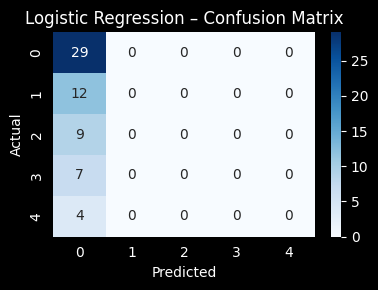

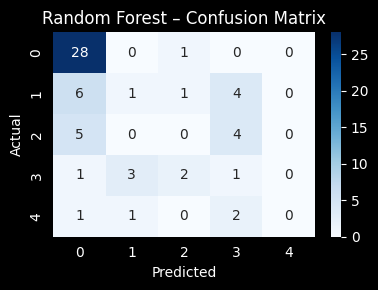

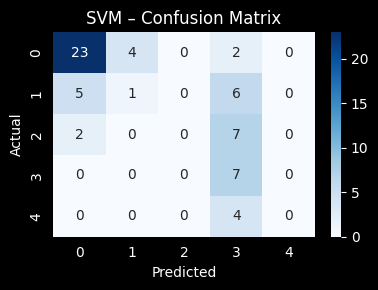

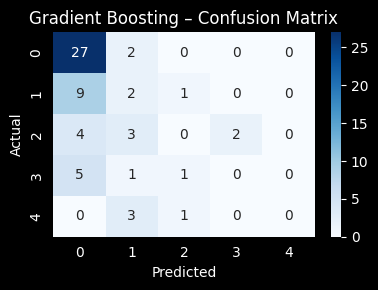

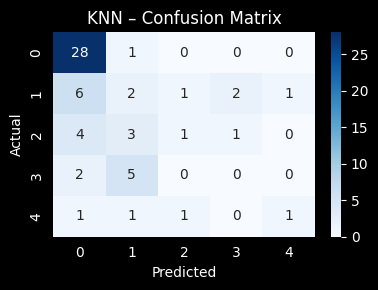

In [93]:
for name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} – Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

### Conclusion

Above, I explored the use of different supervised machine learning models to predict heart disease based on the attributes that are listed as features in Heart Disease Dataset from UCI Machine Learning Repository. Models included were; ogistic Regression, Random Forest, Support Vector Machine, Gradient Boosting, and K-Nearest Neighbors.

Out of those 5 models, tree-based models (Random Forest and Gradient Boosting) proved to have higher accuracy, and ROC AUC values compared to other 3 models.

##### What Went Well
GridSearchCV helped greatly with model performance. Comparing multiple models helped with trade-off analysis.

##### Limitations
The dataset was small, increasing the risk of overfitting.